# Download Data

Download the BTC-USD Dataset from Perplexity Finance.

Save the file into the directory ./data/raw/

# Initialization

In [2]:
%load_ext dotenv
%dotenv 

# Mlflow

In [3]:
import mlflow

mlflow.autolog()

In [4]:
#%pip install mplfinance
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


## Importing Dataset

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import sys

import matplotlib.pyplot as plt
#import mplfinance as mpf


# Add the src directory to the path
src_dir = os.getenv('SRC_DIR')
if src_dir is None:
	# Fallback: assume notebooks folder is one level below project root
	project_root = os.path.dirname(os.getcwd())
	src_dir = os.path.join(project_root, 'src')

print(f"Adding to path: {src_dir}")
sys.path.append(src_dir)

from utils.logger import get_logger
_logs = get_logger(__name__)

2025/11/15 10:15:45 WARNING mlflow.utils.autologging_utils: MLflow statsmodels autologging is known to be compatible with 0.12.2 <= statsmodels <= 0.14.4, but the installed version is 0.14.5. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a compatible version, or try upgrading MLflow.
2025/11/15 10:15:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


Adding to path: ../src/


In [6]:
import hashlib

# Load data
# Define ordered column names to enforce consistent schema (overrides original file header)
columns = [
    'Date', 
    'Close',          
    'Open', 
    'High',                
    'Low', 
    'Volume'
]

btc_file = os.getenv("BTC_DATA")

# Read the raw CSV:
# - header=0 reads the first line (original names) but they are replaced by 'columns'
# - names=columns ensures consistent snake_case naming initialize above
btc_dt = (pd.read_csv(btc_file, header = 0, names = columns))

# Save processed data to a new CSV folder and appeand file name with hash value
    
# Create a hash of the DataFrame
df_hash = hashlib.md5(btc_dt.to_csv(index=False).encode()).hexdigest()
processed_btc_file = os.getenv("PROCESSED_BTC_DATA").replace(".csv", f"_{df_hash}.csv")
btc_dt.to_csv(processed_btc_file, index=False)

# Log the completion of data loading and feature creation and record file name
_logs.info("Loaded BTC-USD dataset into DataFrame.")
_logs.info(f"Processed BTC-USD dataset saved to: {processed_btc_file}")

2025-11-15 10:15:46,181, 2713969401.py, 29, INFO, Loaded BTC-USD dataset into DataFrame.
2025-11-15 10:15:46,182, 2713969401.py, 30, INFO, Processed BTC-USD dataset saved to: ../data/processed/btc_processed_8d4c513d70341c9eb8c09d7c4aa06be1.csv


# Exploratory Data Analysis

The exploratory analysis is the same as *btc_price_prediction.ipynb*. Please refer to that notebook for Data Analysis information 

# Feature Engineering

In [7]:
import numpy as np

# Ensure Date is datetime
btc_dt['Date'] = pd.to_datetime(btc_dt['Date'])
# Set date as index
btc_dt = btc_dt.set_index('Date',drop=False)


btc_dt['Year'] = btc_dt.index.year
btc_dt['Month'] = btc_dt.index.month
btc_dt['Day'] = btc_dt.index.day

btc_dt['is_quarter_end'] = np.where(btc_dt['Month']%3==0,1,0)

# Signal whether to buy or not
btc_dt['Open-Close']  = btc_dt['Open'] - btc_dt['Close']
btc_dt['Low-High']  = btc_dt['Low'] - btc_dt['High']

btc_dt.head()

,Date,Close,Open,High,Low,Volume,Year,Month,Day,is_quarter_end,Open-Close,Low-High
Date,,,,,,,,,,,,
2020-11-05,2020-11-05,15608.21,14165.86,15775.00,14115.00,40856321439,2020,11,5,0,-1442.35,-1660.00
2020-11-06,2020-11-06,15599.95,15608.06,15977.67,15190.36,39837841971,2020,11,6,0,8.11,-787.31
2020-11-07,2020-11-07,14834.09,15599.95,15779.24,14310.00,35024953706,2020,11,7,0,765.86,-1469.24
2020-11-08,2020-11-08,15482.90,14834.09,15666.00,14721.90,26632075029,2020,11,8,0,-648.81,-944.10
2020-11-09,2020-11-09,15342.25,15482.89,15856.90,14817.14,34149115566,2020,11,9,0,140.64,-1039.76


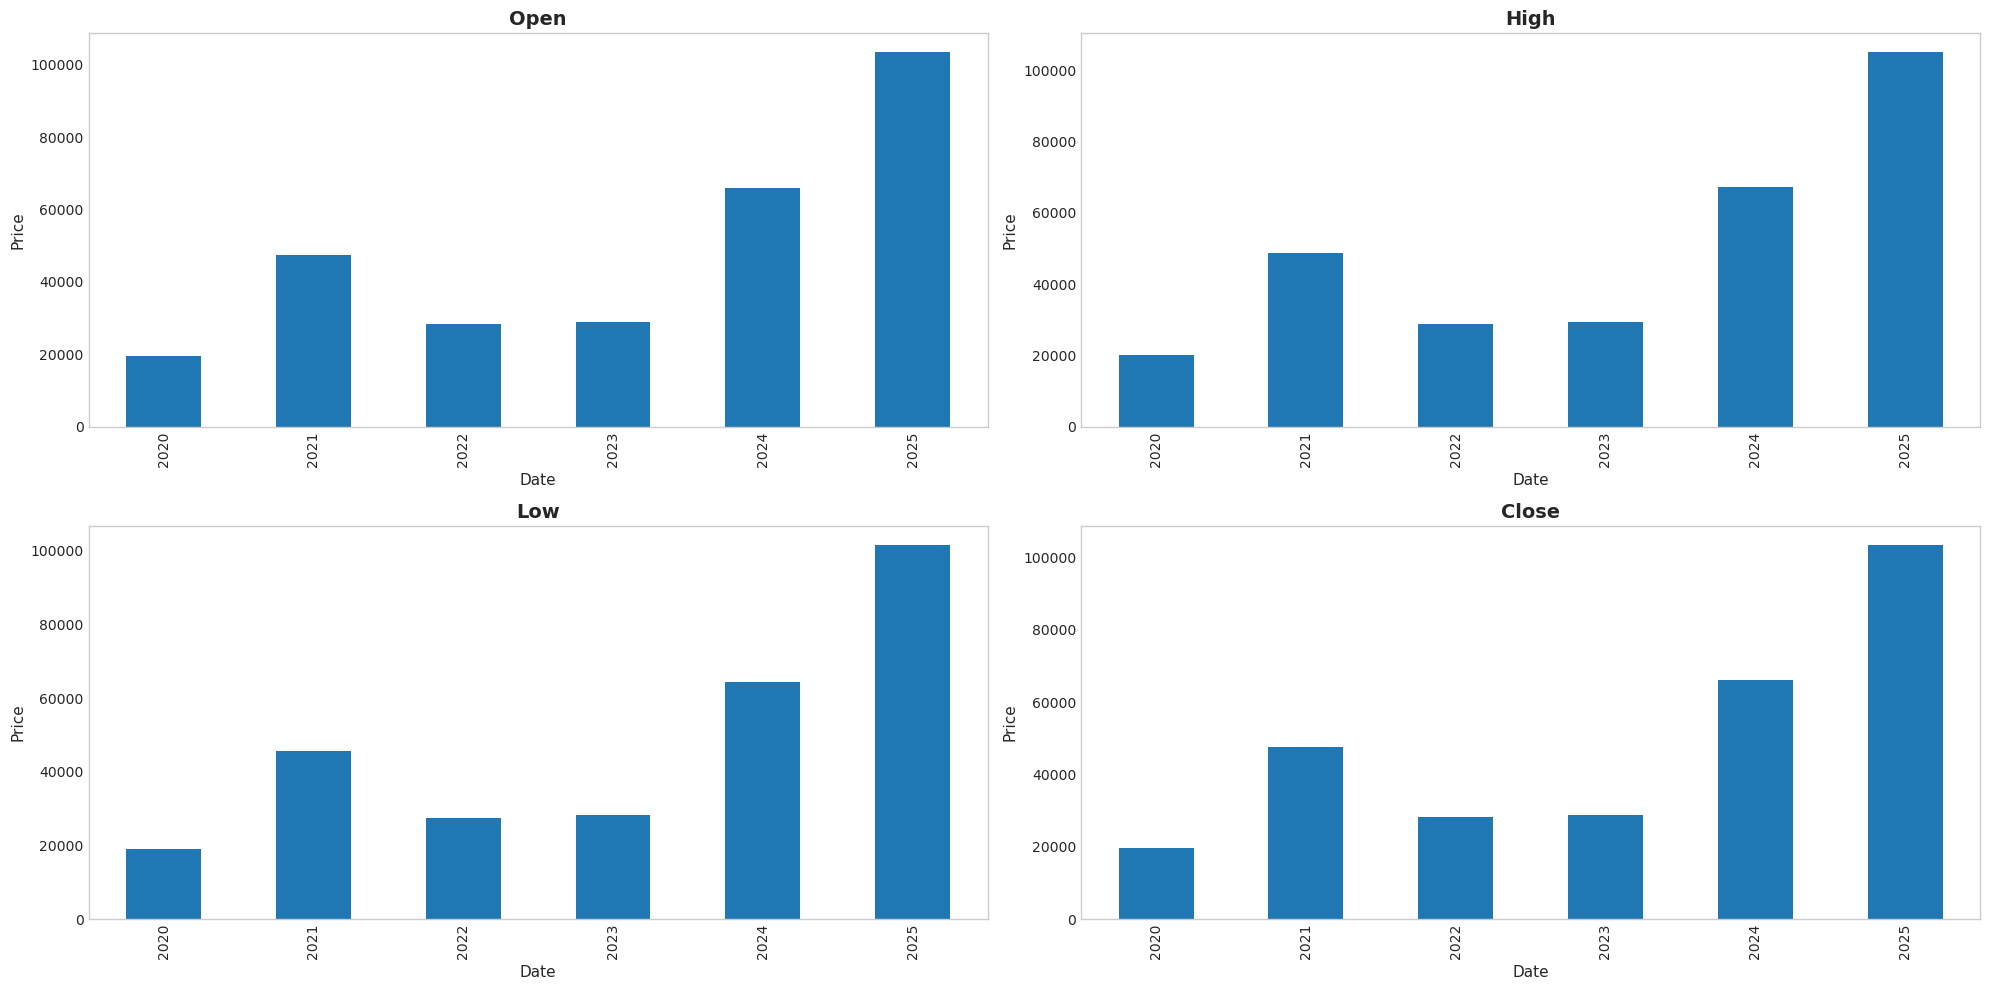

In [8]:
data_grouped = btc_dt.groupby('Year').mean()
# Style sheet
plt.style.use('seaborn-v0_8-whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for ax, col in zip(axes.flatten(), ['Open', 'High', 'Low', 'Close']):
    data_grouped[col].plot.bar(ax=ax, grid=False)
    ax.set_title(col, fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Price', fontsize=11)

plt.tight_layout()
plt.show()

In [9]:
# Technical Analysis Features

# Moving Averages
btc_dt['MA_7'] = btc_dt['Close'].rolling(window=7).mean()
btc_dt['MA_14'] = btc_dt['Close'].rolling(window=14).mean()
btc_dt['MA_21'] = btc_dt['Close'].rolling(window=21).mean()
btc_dt['MA_50'] = btc_dt['Close'].rolling(window=50).mean()
btc_dt['MA_200'] = btc_dt['Close'].rolling(window=200).mean()

# Exponential Moving Averages
btc_dt['EMA_12'] = btc_dt['Close'].ewm(span=12, adjust=False).mean()
btc_dt['EMA_26'] = btc_dt['Close'].ewm(span=26, adjust=False).mean()

# MACD (Moving Average Convergence Divergence)
btc_dt['MACD'] = btc_dt['EMA_12'] - btc_dt['EMA_26']
btc_dt['MACD_Signal'] = btc_dt['MACD'].ewm(span=9, adjust=False).mean()
btc_dt['MACD_Histogram'] = btc_dt['MACD'] - btc_dt['MACD_Signal']

# Relative Strength Index (RSI)
delta = btc_dt['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
btc_dt['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
btc_dt['BB_Middle'] = btc_dt['Close'].rolling(window=20).mean()
bb_std = btc_dt['Close'].rolling(window=20).std()
btc_dt['BB_Upper'] = btc_dt['BB_Middle'] + (bb_std * 2)
btc_dt['BB_Lower'] = btc_dt['BB_Middle'] - (bb_std * 2)
btc_dt['BB_Width'] = btc_dt['BB_Upper'] - btc_dt['BB_Lower']

# Price Rate of Change (ROC)
btc_dt['ROC'] = ((btc_dt['Close'] - btc_dt['Close'].shift(10)) / btc_dt['Close'].shift(10)) * 100

# Average True Range (ATR) - Volatility Indicator
high_low = btc_dt['High'] - btc_dt['Low']
high_close = np.abs(btc_dt['High'] - btc_dt['Close'].shift())
low_close = np.abs(btc_dt['Low'] - btc_dt['Close'].shift())
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
btc_dt['ATR'] = true_range.rolling(window=14).mean()

# Stochastic Oscillator
low_14 = btc_dt['Low'].rolling(window=14).min()
high_14 = btc_dt['High'].rolling(window=14).max()
btc_dt['Stochastic_%K'] = 100 * ((btc_dt['Close'] - low_14) / (high_14 - low_14))
btc_dt['Stochastic_%D'] = btc_dt['Stochastic_%K'].rolling(window=3).mean()

# On-Balance Volume (OBV)
btc_dt['OBV'] = (np.sign(btc_dt['Close'].diff()) * btc_dt['Volume']).fillna(0).cumsum()

# Volume Rate of Change
btc_dt['Volume_ROC'] = ((btc_dt['Volume'] - btc_dt['Volume'].shift(5)) / btc_dt['Volume'].shift(5)) * 100

# Price momentum
btc_dt['Momentum'] = btc_dt['Close'] - btc_dt['Close'].shift(4)

# Percentage change features
btc_dt['Daily_Return'] = btc_dt['Close'].pct_change() * 100
btc_dt['Volatility_10'] = btc_dt['Daily_Return'].rolling(window=10).std()
btc_dt['Volatility_30'] = btc_dt['Daily_Return'].rolling(window=30).std()


In [10]:
def create_labels(df, threshold=0.01, forward_days=7):
        """
        Create Bullish/Bearish labels based on future returns
        Bullish (1) if price increases > threshold in next forward_days
        Bearish (0) otherwise
        """
        df = df.copy()
        df['Future_Return'] = df['Close'].shift(-forward_days) / df['Close'] - 1
        df['Target'] = (df['Future_Return'] > threshold).astype(int)
        return df

Bullish signals (1): 726 (39.74%)
Bearish signals (0): 1101 (60.26%)


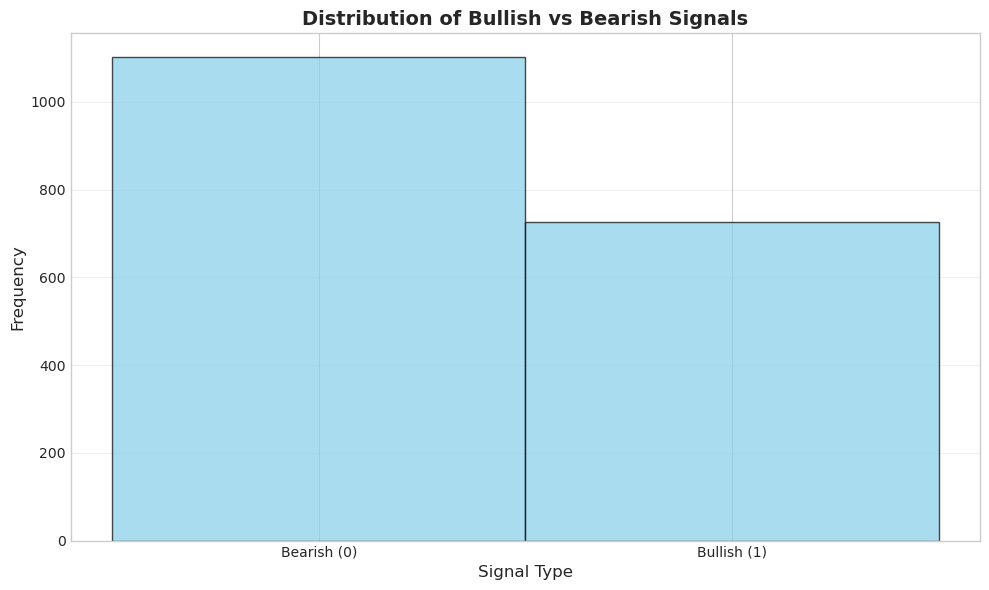

In [11]:
btc_dt = create_labels(btc_dt,0.02,7)

print(f"Bullish signals (1): {btc_dt['Target'].sum()} ({btc_dt['Target'].sum()/len(btc_dt)*100:.2f}%)")
print(f"Bearish signals (0): {(btc_dt['Target']==0).sum()} ({(btc_dt['Target']==0).sum()/len(btc_dt)*100:.2f}%)")

plt.figure(figsize=(10, 6))
plt.hist(btc_dt['Target'], bins=2, color='skyblue', edgecolor='black', alpha=0.7)
plt.xticks([0.25, 0.75], ['Bearish (0)', 'Bullish (1)'])
plt.xlabel('Signal Type', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Bullish vs Bearish Signals', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


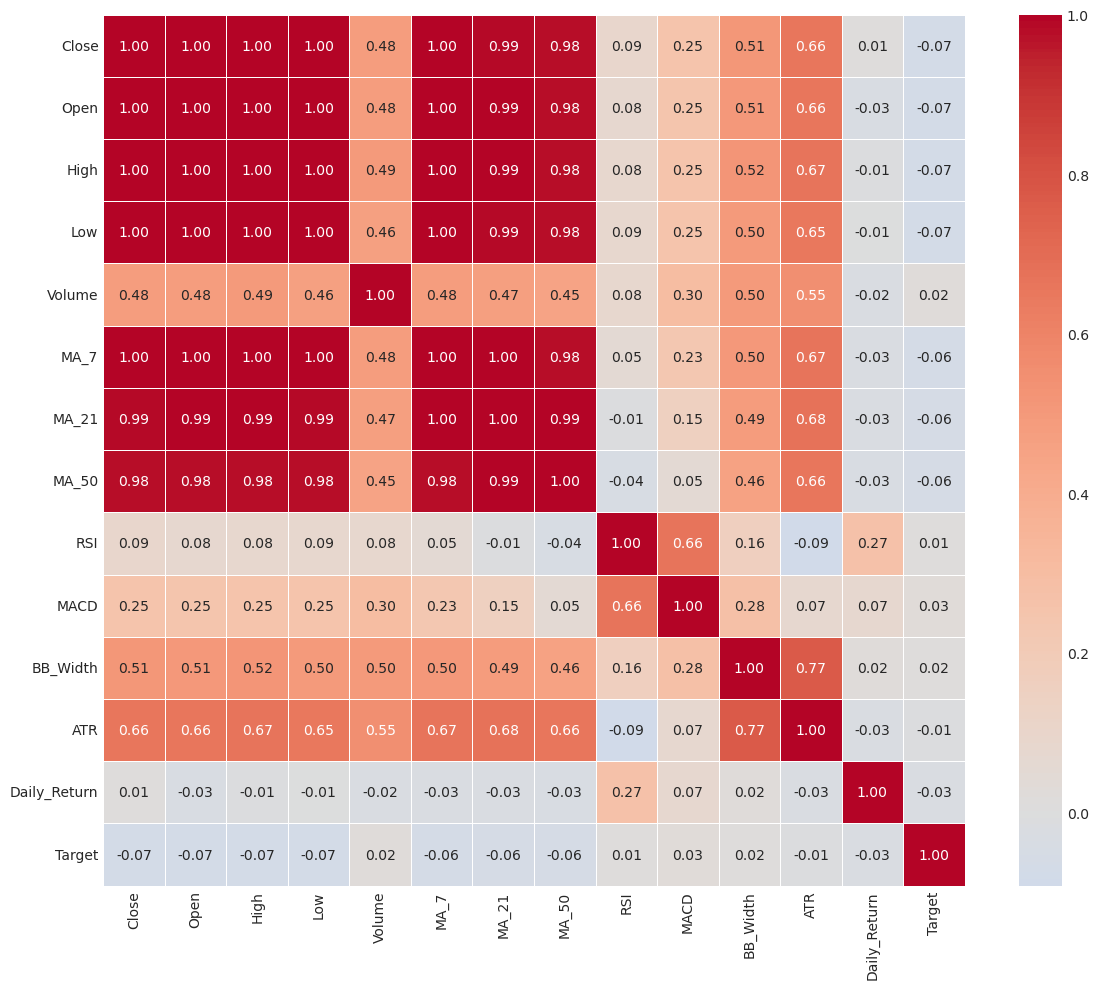

In [12]:
# Correlation Heatmap - simplified version
# Selecting most important features to reduce visual clutter
important_features = ['Close', 'Open', 'High', 'Low', 'Volume',
                      'MA_7', 'MA_21', 'MA_50', 'RSI', 'MACD',
                      'BB_Width', 'ATR', 'Daily_Return', 'Target']

plt.figure(figsize=(12, 10))
sb.heatmap(btc_dt[important_features].corr(), annot=True, cbar=True, fmt='.2f',
           cmap='coolwarm', center=0, linewidths=0.5)
#plt.title("Feature Correlation Heatmap (Key Features)")
plt.tight_layout()
plt.show()


# Model Development


In [ ]:
# TensorFlow/Keras imports
import tensorflow as tf
from tf_keras import layers, Model
from transformers import TFBertModel, AutoTokenizer
from tf_keras.optimizers import Adam
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tf_keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,CSVLogger
from sklearn.utils.class_weight import compute_class_weight

def build_finbert_bitcoin_classifier(num_features=32,
                                     window_size=14,
                                     max_length=64,
                                     dropout=0.3):
    print("Building model...\n")

    # FinBERT branch
    input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

    finbert = TFBertModel.from_pretrained('ProsusAI/finbert')
    finbert.trainable = False  # FREEZE FinBERT

    bert_output = finbert(input_ids, attention_mask=attention_mask)
    sentiment = layers.Dense(64, activation='relu', name='sentiment')(bert_output.pooler_output)

    #twitter
    twitter_input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='twitter_input_ids')
    twitter_attention_mask = layers.Input(shape=(max_length,), dtype=tf.int32, name='twitter_attention_mask')
    twitter_mask = layers.Input(shape=(1,), dtype=tf.float32, name='twitter_mask')

    # Shared FinBERT weights (processes Twitter with same financial knowledge)
    twitter_bert_output = finbert(twitter_input_ids, attention_mask=twitter_attention_mask)
    twitter_sentiment = layers.Dense(64, activation='relu', name='twitter_sentiment')(twitter_bert_output.pooler_output)

    # Apply mask (zero out when Twitter unavailable)
    twitter_masked = layers.Multiply(name='twitter_masked')([twitter_sentiment, twitter_mask])

    # Combine news + Twitter sentiments
    sentiment_features = layers.Concatenate(name='combined_sentiment')([sentiment, twitter_masked])
    sentiment_features = layers.Dense(64, activation='relu', name='sentiment_fusion')(sentiment_features)

    #CNN Branch (Technical Indicators)
    tech_input = layers.Input(shape=(num_features, window_size), name='technical_data')

    conv1 = layers.Conv1D(64, 3, activation='relu', padding='same')(tech_input)
    pool1 = layers.MaxPooling1D(2)(conv1)
    flatten = layers.Flatten()(pool1)
    tech_features = layers.Dense(64, activation='relu')(flatten)
    # Combine and classify
    combined = layers.Concatenate()([sentiment_features, tech_features])

    # Attention layer (learn importance of sentiment vs technical)
    attention = layers.Dense(128, activation='tanh')(combined)
    attention_weights = layers.Dense(128, activation='softmax')(attention)
    attended = layers.Multiply()([combined, attention_weights])

    dense1 = layers.Dense(64, activation='relu')(attended)
    dropout = layers.Dropout(0.3)(dense1)
    output = layers.Dense(2, activation='softmax')(dropout)

    model = Model(
        inputs = [input_ids,attention_mask,
        twitter_input_ids,twitter_attention_mask,twitter_mask,
        tech_input
        ],
        outputs=output,
        name='Dual_Finbert_Bitcoin_Classifier'
    )

    print(f"Model created - {model.count_params():,} parameters")
    return model

In [ ]:
def train_model(model, train_data, val_data, epochs=10):
    print("Training model...\n")

    # Calculate class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_data['labels']),
        y=train_data['labels']
    )
    class_weight_dict = {
      0: class_weights[0],  # Bearish
      1: class_weights[1]   # Bullish
    }

    model.compile(
        optimizer=Adam(3e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        # Stop when validation loss stops improving
        EarlyStopping(
            monitor='val_loss',
            patience=10,  # Wait 10 epochs before stopping
            restore_best_weights=True,
            verbose=1,
            modce='min'
        ),
        # Save best model
        ModelCheckpoint(
            'best_cnn_dual_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            mode='max'
            ),

        # Reduce learning rate when plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,  # Reduce by half
            patience=5,  # After 5 epochs of no improvement
            min_lr=1e-7,
            verbose=1,
            mode='min'
        )
    ]

    history = model.fit(
        {
            'input_ids': train_data['input_ids'],
            'attention_mask': train_data['attention_mask'],
            'twitter_input_ids': train_data['twitter_input_ids'],
            'twitter_attention_mask': train_data['twitter_attention_mask'],
            'twitter_mask': train_data['twitter_mask'],
            'technical_data': train_data['technical_data'],
        },
        train_data['labels'],
        validation_data=(
            {
                'input_ids': val_data['input_ids'],
                'attention_mask': val_data['attention_mask'],
                'twitter_input_ids': test_data['twitter_input_ids'],
                'twitter_attention_mask': test_data['twitter_attention_mask'],
                'twitter_mask': test_data['twitter_mask'],
                'technical_data': val_data['technical_data']
            },
            val_data['labels']
        ),
        epochs=epochs,
        batch_size=32,
        class_weight=class_weight_dict,
        callbacks = callbacks,
        verbose=1
    )

    return history

In [15]:
# Report the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_model(model, test_data):
    print("Evaluating model...\n")

    predictions = model.predict({
        'input_ids': test_data['input_ids'],
        'attention_mask': test_data['attention_mask'],
        'twitter_input_ids': test_data['twitter_input_ids'],
        'twitter_attention_mask': test_data['twitter_attention_mask'],
        'twitter_mask': test_data['twitter_mask'],
        'technical_data': test_data['technical_data']
    }, verbose=0)

    pred_classes = np.argmax(predictions, axis=1)
    pred_probs = predictions[:,1]
    true_labels = test_data['labels']

    print("\n" + "="*60)
    print("RESULTS")
    print("="*60)
    print(classification_report(true_labels, pred_classes,
                                target_names=['Bearish', 'Bullish']))

    plot_confusion_matrix(true_labels,pred_classes,['Bearish','Bullish'])

    # Calculate ROC-AUC
    try:
        roc_auc = roc_auc_score(true_labels, pred_probs)
        print(f"ROC-AUC Score: {roc_auc:.4f}\n")
    except:
        roc_auc = None
        print("ROC-AUC Score: N/A\n")

    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate', fontsize=11)
    plt.ylabel('True Positive Rate', fontsize=11)
    plt.title('ROC Curve', fontsize=12, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    accuracy = (pred_classes == true_labels).mean() * 100
    print(f" Test Accuracy: {accuracy:.2f}%\n")
    print("="*60)

    return accuracy

# Sentiment dataset pre-processing

In [17]:
def clean_sentiment(sentiment_dt):

 sentiment_dt['Week_Start'] = pd.to_datetime(sentiment_dt['Week_Start'])
 sentiment_dt['Week_End'] =  pd.to_datetime(sentiment_dt['Week_End'])
 sentiment_dt['Week_Start'] = pd.to_datetime(sentiment_dt['Week_Start'])
 sentiment_dt['Week_End'] =  pd.to_datetime(sentiment_dt['Week_End'])
 
 # Clean the Summary
 sentiment_dt['Sentiment_Text'] = sentiment_dt['Summary'].str.replace(r'[\n\r\t]',' ',regex=True)
 sentiment_dt['Sentiment_Text'] = sentiment_dt['Sentiment_Text'].str.replace(r'[^a-zA-Z0-9\s.,!?\-\']','',regex=True)
 
 return sentiment_dt

In [ ]:
def clean_twitter_txt(df):

 #Clean twitter data
 df['date'] = pd.to_datetime(df['date'], errors='coerce')
 df = df.dropna(subset=['text'])
 df['date_only'] = pd.to_datetime(df['date']).dt.normalize()
 df['text'] = df['text'].str.replace(r'[\n\r\t]',' ',regex=True)
 df['Twitter_Text'] = df['text'].str.replace(r'[^a-zA-Z0-9\s.,!?\-\']','',regex=True)
 df = df[df['user_verified'] == 'True']\
    .sort_values(by=['date_only','user_followers','user_favourites'],ascending=False)\
    .groupby('date_only')['Twitter_Text']\
    .apply(
        lambda t: ' '.join(t)
    ).reset_index()

 return df

In [18]:
file = os.getenv("SENTIMENT_DATA")

# Read the raw CSV:
# - header=0 reads the first line (original names) but they are replaced by 'columns'
# - names=columns ensures consistent snake_case naming initialize above
cols = ['Week','Week_Code','Week_Start','Week_End','Sentiment','Price_Start','Price_End','Price_Avg','Price_Change','Agreement','Summary']
sent_dt = (pd.read_csv(file, header = 0, names =cols ))
sent_dt = clean_sentiment(sent_dt)

# Save processed data to a new CSV folder and appeand file name with hash value
# Create a hash of the DataFrame
df_hash = hashlib.md5(sent_dt.to_csv(index=False).encode()).hexdigest()
processed_sentiment_file = os.getenv("PROCESSED_SENTIMENT_DATA").replace(".csv", f"_{df_hash}.csv")
sent_dt.to_csv(processed_sentiment_file, index=False)

In [ ]:
file = os.getenv('TWITTER_DATA')

# Read the raw CSV:
# - header=0 reads the first line (original names) but they are replaced by 'columns'
# - names=columns ensures consistent snake_case naming initialize above
t_dt = pd.read_csv(file)
t_dt = clean_twitter_txt(t_dt)

# Save processed data to a new CSV folder and appeand file name with hash value
# Create a hash of the DataFrame
df_hash = hashlib.md5(t_dt.to_csv(index=False).encode()).hexdigest()
processed_sentiment_file = os.getenv("PROCESSED_TWITTER_DATA").replace(".csv", f"_{df_hash}.csv")
t_dt.to_csv(processed_sentiment_file, index=False)

/tmp/ipython-input-3551675020.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date_only'] = pd.to_datetime(df['date']).dt.normalize()
/tmp/ipython-input-3551675020.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].str.replace(r'[\n\r\t]',' ',regex=True)
/tmp/ipython-input-3551675020.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [ ]:
t_dt

,date_only,Twitter_Text
0,2021-02-10,blockstreamaqua is our new bitcoin and wallet...
1,2021-02-19,'while bitcoin may very well continue to be vo...
2,2021-02-22,"live bitcoin price crash wipes 10,000 from its..."
3,2021-04-05,crypto brief bitcoin ethereum bitcoinnews e...
4,2021-04-18,"bitcoin sinks 10 to 55,000 amid regulatory fea..."
...,...,...
124,2022-11-09,"imagine being able to buy btc at 15,700... oh..."
125,2022-11-15,most advocates don't know how...need a brillia...
126,2022-11-21,which project should i buy? bitcoin altcoin me...
127,2022-12-25,"my eoy price predictions btc 16,826 eth 1,218"


In [ ]:
from sklearn.preprocessing import LabelEncoder
def prepare_data_dual_sentiment(df,sentiment_df,t_df,tokenizer,tech_columns, window_size = 7, max_length=64):

    encoder = LabelEncoder()
    sentiment_df['Sentiment'] = encoder.fit_transform(sent_dt['Sentiment'])
    df =  df.merge(sentiment_df, how='cross')
    df = df[(df['Date'] >= df['Week_Start']) & (df['Date']<= df['Week_End'])]
    df = df.merge(t_df,how='left',left_on=['Date'],right_on=['date_only'])

    input_ids_list = []
    attention_mask_list = []
    twitter_input_ids_list = []
    twitter_attention_mask_list = []
    twitter_mask_list = []
    technical_data_list = []
    labels_list = []


    for idx in range(len(df) - window_size):
        # Get window of technical indicators
        start_idx = idx
        end_idx = idx + window_size

        tech_data = df.iloc[start_idx:end_idx][tech_columns].values
        tech_data = tech_data.T  # Shape: (features, window_size)

        # Get news text for the last day in window
        news_text = df.iloc[end_idx - 1]['Sentiment_Text']
        encoding = tokenizer(
            news_text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='np'
        )

        twitter_text = df.iloc[end_idx - 1].get('Twitter_Text', None)
        if twitter_text and not pd.isna(twitter_text) and str(twitter_text).strip():
            # Real Twitter data available
            twitter_encoding = tokenizer(
                str(twitter_text),
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors='np'
            )
            twitter_mask = 1.0
        else:
            # No Twitter data - use empty input (will be masked out in model)
            twitter_encoding = tokenizer(
                "",
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors='np'
            )
            twitter_mask = 0.0

        # Get label
        label = df.iloc[end_idx - 1]['Target']

        #Append all values
        input_ids_list.append(encoding['input_ids'][0])
        attention_mask_list.append(encoding['attention_mask'][0])
        twitter_input_ids_list.append(twitter_encoding['input_ids'][0])
        twitter_attention_mask_list.append(twitter_encoding['attention_mask'][0])
        twitter_mask_list.append([twitter_mask])
        technical_data_list.append(tech_data)
        labels_list.append(label)

    return {
        'input_ids': np.array(input_ids_list),
        'attention_mask': np.array(attention_mask_list),
        'twitter_input_ids': np.array(twitter_input_ids_list),
        'twitter_attention_mask': np.array(twitter_attention_mask_list),
        'twitter_mask': np.array(twitter_mask_list),
        'technical_data': np.array(technical_data_list),
        'labels': np.array(labels_list)
    }

# Main model execution

In [ ]:
# Prepare data - drop rows with NaN values and select features
# We drop instead of replace to maintain data integrity
ml_data = btc_dt.dropna().copy()
# Select features for modeling (excluding target and date-related features)
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume',
                'Open-Close', 'Low-High',
                'MA_7', 'MA_14', 'MA_21', 'MA_50', 'MA_200',
                'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram',
                'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width',
                'ROC', 'ATR', 'Stochastic_%K', 'Stochastic_%D',
                'OBV', 'Volume_ROC', 'Momentum', 'Daily_Return',
                'Volatility_10', 'Volatility_30']
WINDOW_SIZE= 10
MAX_LENGTH = 256
EPOCHS=30

# Load tokenizer
print("Loading FinBERT tokenizer...\n")
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')

# Split data (80% train, 20% test)
split_idx = int(0.8 * len(ml_data))
train_df = ml_data.iloc[:split_idx]
test_df = ml_data.iloc[split_idx:]

# Normalize technical indicators
scaler = RobustScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

# Add encoded variable
feature_cols.append('Sentiment')

# Prepare data
train_data = prepare_data_dual_sentiment(train_df,sent_dt,t_dt, tokenizer, feature_cols, WINDOW_SIZE, MAX_LENGTH)
test_data = prepare_data_dual_sentiment(test_df,sent_dt,t_dt,tokenizer,feature_cols, WINDOW_SIZE, MAX_LENGTH)

print(f"\nTrain samples: {len(train_data['labels'])}")
print(f"Test samples:  {len(test_data['labels'])}")

# Build model
model = build_finbert_bitcoin_classifier(num_features=33, window_size=WINDOW_SIZE, max_length=MAX_LENGTH)
model.summary()
# Train
history = train_model(model, train_data, test_data, epochs=EPOCHS)

Loading FinBERT tokenizer...



/tmp/ipython-input-1219134934.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
/tmp/ipython-input-1219134934.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[feature_cols] = scaler.transform(test_df[feature_cols])



Train samples: 1286
Test samples:  315
Building model...



All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model created - 109,697,922 parameters
Model: "Dual_Finbert_Bitcoin_Classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 twitter_input_ids (InputLa  [(None, 256)]                0         []                            
 yer)                                                                                             
                             

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 60s 853ms/step - loss: 0.6932 - accuracy: 0.4541 - val_loss: 0.6922 - val_accuracy: 0.6444 - lr: 3.0000e-05
Epoch 2/30
41/41 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.4720
Epoch 2: val_accuracy did not improve from 0.64444
41/41 [==============================] - 27s 659ms/step - loss: 0.6930 - accuracy: 0.4720 - val_loss: 0.6926 - val_accuracy: 0.5683 - lr: 3.0000e-05
Epoch 3/30
41/41 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.4642
Epoch 3: val_accuracy did not improve from 0.64444
41/41 [==============================] - 27s 659ms/step - loss: 0.6929 - accuracy: 0.4642 - val_loss: 0.6930 - val_accuracy: 0.5079 - lr: 3.0000e-05
Epoch 4/30
41/41 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.4984
Epoch 4: val_accuracy did not improve from 0.64444
41/41 [==============================] - 27s 660ms/step - loss: 0.6927 - accuracy: 0.4984 - val_loss: 0.6925 - val_acc

# Model Evaluation

Evaluating model...


RESULTS
              precision    recall  f1-score   support

     Bearish       0.66      0.91      0.76       207
     Bullish       0.37      0.10      0.16       108

    accuracy                           0.63       315
   macro avg       0.51      0.51      0.46       315
weighted avg       0.56      0.63      0.56       315



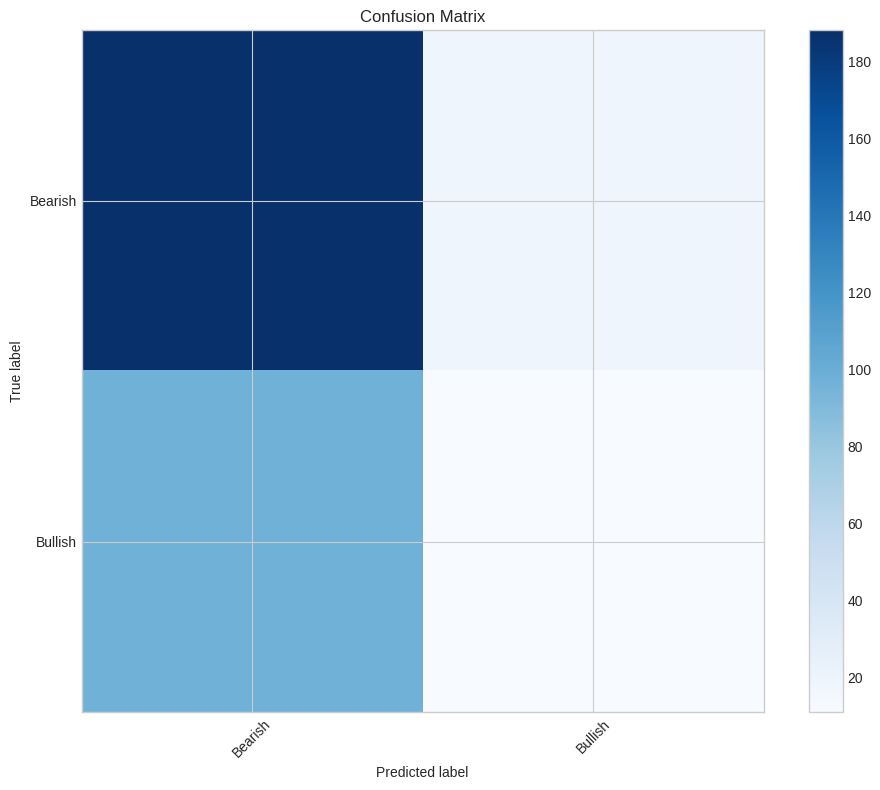

ROC-AUC Score: 0.5245

 Test Accuracy: 63.17%



/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 Model saved as: finber_cnn_sentiment_model.h5



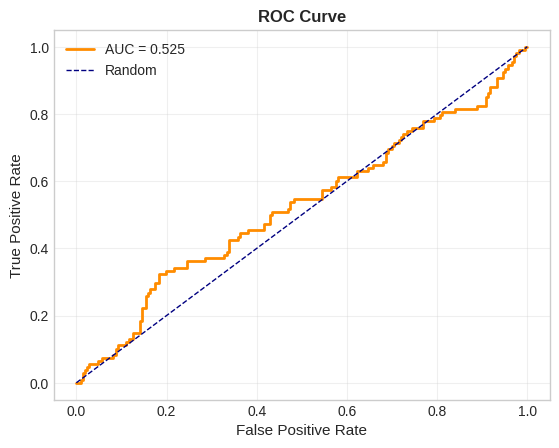

In [ ]:
# Evaluate
accuracy = evaluate_model(model, test_data)

# Save model
model.save('finbert_cnn_sentiment_model.h5')
print(" Model saved as: finber_cnn_sentiment_model.h5\n")

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipython-input-123954670.py:51: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


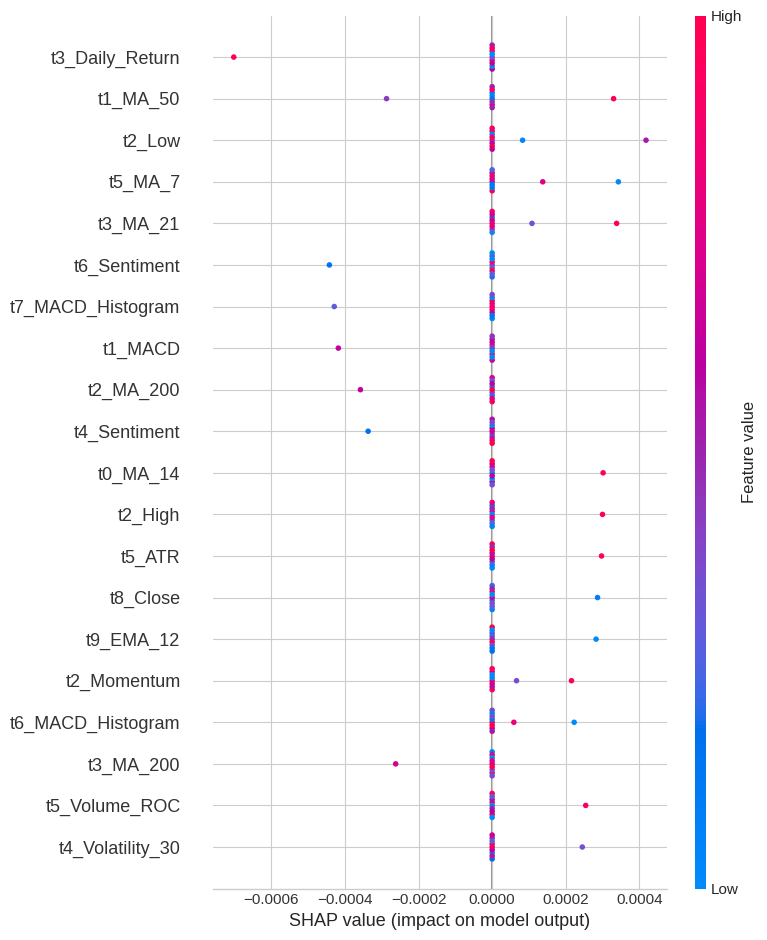

In [ ]:
import shap

# 1. Prepare background data (sample from training set)
np.random.seed(42)

feature_names = []
for t in range(WINDOW_SIZE):
    for indicator in (feature_cols + ['Sentiment']):
        feature_names.append(f't{t}_{indicator}')

# Create prediction function that only varies technical features
def predict_with_tech(tech_data, fixed_ids, fixed_mask,f_twitter_input,f_twitter_attention_mask,f_twitter_mask):
    n_samples = len(tech_data)
    ids_batch = np.repeat(fixed_ids[np.newaxis, :], n_samples, axis=0)
    mask_batch = np.repeat(fixed_mask[np.newaxis, :], n_samples, axis=0)

    twitter_ids_batch = np.repeat(f_twitter_input[np.newaxis, :], n_samples, axis=0)
    twitter_att_mask_batch = np.repeat(f_twitter_attention_mask[np.newaxis, :], n_samples, axis=0)
    twitter_mask_batch = np.repeat(f_twitter_mask[np.newaxis, :], n_samples, axis=0)

    tech_reshaped = tech_data.reshape(-1, 33, WINDOW_SIZE)
    return model.predict([ids_batch, mask_batch,twitter_ids_batch,twitter_att_mask_batch,twitter_mask_batch, tech_reshaped], verbose=0)

# Select one sample to explain
sample_idx = 0
fixed_ids = test_data['input_ids'][sample_idx]
fixed_mask = test_data['attention_mask'][sample_idx]
f_twitter_input_ids = test_data['twitter_input_ids'][sample_idx]
f_twitter_attention_mask = test_data['twitter_attention_mask'][sample_idx]
f_twitter_mask = test_data['twitter_mask'][sample_idx]

train_indices = np.random.choice(len(train_data['labels']), size=50, replace=False)
test_indices = np.random.choice(len(test_data['labels']), size=10, replace=False)

# Background: technical features only
background_tech = train_data['technical_data'][train_indices].reshape(50, -1)

# Test: technical features only
test_tech = test_data['technical_data'][test_indices].reshape(10, -1)

# Create explainer
explainer = shap.KernelExplainer(
    lambda x: predict_with_tech(x, fixed_ids, fixed_mask,f_twitter_input_ids,f_twitter_attention_mask,f_twitter_mask),
    background_tech
)

# Calculate SHAP values
shap_values = explainer.shap_values(test_tech, nsamples=100)

# Visualize
shap.summary_plot(
    shap_values[:, :, 1],  # Class 1 predictions
    test_tech,
    feature_names=feature_names,
    max_display = 20
)